- train on shift=1, ntrials=2, nmaps=4, trlen=?,
- eval on ntrials=2*(nmaps^2) - every possible instruction sequence twice
- assess separation against PI buildup

In [1]:
import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

def mov_avg(arr,wind):
  MA = -np.ones(len(arr)-wind)
  for t in range(len(arr)-wind):
    MA[t] = arr[t:t+wind].mean()
  return MA

In [2]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

def run_net(net,task,neps,ntrials,trlen,training=True):
  '''
  returns score [neps,ntrials,nmaps+trlen]
  '''
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  exp_len = ntrials*(task.nmaps+trlen)
  score = -np.ones([neps,exp_len])
  for ep in range(neps):
    # forward prop
    iseq,xseq,ytarget = task.gen_ep_data(ntrials,trlen)
    yhat_ulog = net(iseq,xseq)
    # eval
    score_t = (maxsoftmax(yhat_ulog) == ytarget).numpy()
    score[ep] = np.squeeze(score_t)
    if training:
      # backprop
      loss = 0
      for tstep in range(len(iseq)):
        loss += lossop(yhat_ulog[tstep],ytarget[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
  score = score.reshape(neps,ntrials,trlen+task.nmaps)
  return score

In [3]:
'''init net task'''
seed = 0
# task
nmaps = 2
ntokens_surplus = 0
switchmaps = 1
# net
stsize = 20
# wmsetting=1
# emsetting=1

# init
# task = TaskArbitraryMaps(nmaps,switchmaps=switchmaps,ntokens_surplus=ntokens_surplus,seed=seed)
# net = NetAMEM(stsize=stsize,emsetting=emsetting,wmsetting=wmsetting,seed=seed)

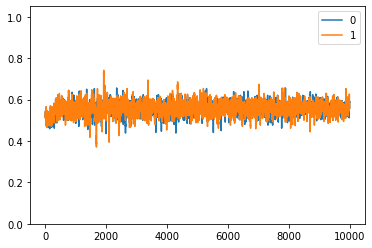

In [6]:
neps = 10000
ntrials,trlen=2,15
for em in [0,1]:
  task = TaskArbitraryMaps(nmaps=nmaps,
                           switchmaps=switchmaps,
                           ntokens_surplus=ntokens_surplus,
                           seed=seed)
  net = NetAMEM(stsize=stsize,
                emsetting=em,
                wmsetting=1,
                seed=seed)
  trsc = run_net(net,task,neps,ntrials,trlen,training=True)
  tracc = trsc.mean((1,2))
  plt.plot(mov_avg(tracc,10),label=em)
plt.ylim(0,1.05)
plt.legend()

In [5]:
# ntrials_ev,trlen_ev = 20,5
# neps_ev = 200
# evsc = run_net(net,task,neps_ev,ntrials_ev,trlen_ev,training=False)
# block_acc = evsc[:,:,task.nmaps:].mean((0,2))
# plt.plot(block_acc)

# evsc = evsc.reshape(neps_ev,ntrials_ev,trlen_ev+task.nmaps)
# print(evsc.shape)
# evacc = evsc[:,:,task.nmaps:].mean((0,2))
# plt.plot(evacc)
# task.nmaps

In [7]:
fdir = 'model_data/amtask-sweep1/'
fpath = 'lstm_20-em_1-nmaps_4-ntrials_1-trlen_30-ntoksurp_0-trsc.npy'

NameError: name 'glob' is not defined